In [2]:
import sys
sys.path.append('/home/punygod_admin/SoundSense/soundsense')

In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
from torch.autograd import Variable
import cv2
import os
import numpy as np
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models.baselines.mulsa.inference import MULSAInference
from models.imi_datasets import ImitationEpisode

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-26 14:11:39.526378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_mha_spec04-22-04:18:40/last.ckpt"
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_mha_spec04-22-04:18:40/hparams.yaml'
with open(config_path) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Using GPU
Creating simple decoder
Total parameters: 36.105352 Million
NUM STACK:  6


In [5]:

np.random.seed(0)
run_ids = os.listdir('/home/punygod_admin/SoundSense/soundsense/data/mulsa/sorting')
np.random.permutation(run_ids)
train_val_split = 0.8
split = int(train_val_split*len(run_ids))
train_episodes = run_ids[:split]
val_episodes = run_ids[split:]

print("Train episodes: ", len(train_episodes))
print("Val episodes: ", len(val_episodes))
val_set = torch.utils.data.ConcatDataset(
    [
        ImitationEpisode(config, run_id, train=False)
        for run_id in val_episodes
    ]
)

val_loader = DataLoader(val_set, num_workers=config["num_workers"], shuffle=False,batch_size=1)

Train episodes:  79
Val episodes:  20


## New code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

cuda:0


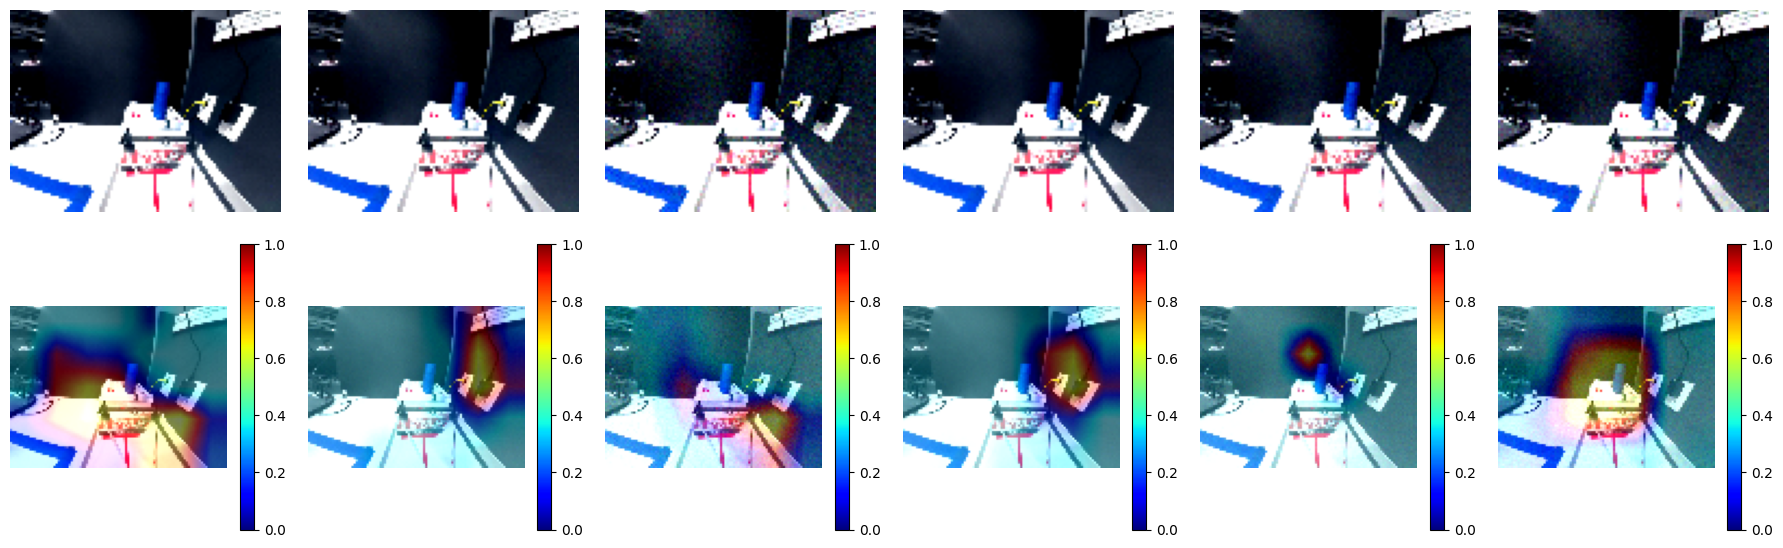

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for itr, (img, target) in enumerate(val_loader):
    img[0] = img[0].squeeze(0)
    img[0] = img[0].permute(0, 2, 3, 1)
    # print(img[1].squeeze(0).shape)
    inp = {"video": np.array(img[0]), "audio": img[1].squeeze(0).to(device)}  

    # Forward pass through the model
    output = model(inp)
    output = output[0][-1].reshape(1,-1)
    # print(output.data.shape)
    _, predicted_class = torch.max(output.data, 1)

    if predicted_class != 0:
        continue

    # Compute the gradients of the predicted class output with respect to the feature maps
    model.zero_grad()
    output[:, predicted_class].backward()


    # Get the gradients from the last convolutional layer
    v_grads, a_grads = model.get_activations_gradient()
    # print("v_grads: ", v_grads.shape) # torch.Size([6, 512, 5, 7])

    # Get the feature maps from the last convolutional layer
    v_maps, a_maps = model.get_activations()
    # print("v_maps: ", v_maps.shape) # torch.Size([6, 512, 5, 7])

    # Perform global average pooling on the gradients
    v_pooled_grads = torch.mean(v_grads, dim=(2, 3))
    # print("v_pooled_grads: ", v_pooled_grads.shape) # torch.Size([6, 512])

    # Multiply each feature map by its corresponding gradient value
    for i in range(v_maps.shape[1]):
        for j in range(v_maps.shape[0]):
            v_maps[j, i, :, :] *= v_pooled_grads[j, i]
    # print("v_maps: ", v_maps.shape) # torch.Size([6, 512, 5, 7])
    
    # Obtain the heatmap by averaging the weighted feature maps
    v_heatmap = torch.mean(v_maps, dim=1).squeeze().cpu()
    # print("v_heatmap: ", v_heatmap.shape) # torch.Size([6, 5, 7])

    # Normalize the heatmap
    v_heatmap = torch.maximum(v_heatmap, torch.zeros_like(v_heatmap))
    # print("v_heatmap: ", v_heatmap.shape) # torch.Size([6, 5, 7])
    # print(type(v_heatmap)) # <class 'torch.Tensor'>
    # print(torch.max(torch.max(v_heatmap, dim=1)[0], dim=1)[0]) 

    v_heatmap_max = torch.max(torch.max(v_heatmap, dim=1)[0], dim=1)[0] # torch.Size([6])
    for i in range(v_heatmap.shape[0]):
        v_heatmap[i] /= v_heatmap_max[i]

    # print("v_heatmap: ", v_heatmap.shape) # torch.Size([6, 5, 7])
    
    # Resize the heatmap to match the input image size
    img[0] = img[0].permute(0, 3, 1, 2)
    # print("img[0].shape: ", img[0].shape) # torch.Size([6, 3, 75, 100])


    v_heatmap = v_heatmap.numpy()
    v_heatmap_resized = np.zeros((v_heatmap.shape[0], img[0].shape[2], img[0].shape[3])) # (6, 75, 100)

    for i in range(v_heatmap.shape[0]):
      v_heatmap_resized[i] = cv2.resize(v_heatmap[i], (img[0].shape[3], img[0].shape[2])) # (75, 100)

    v_heatmap_resized = (255 * v_heatmap_resized).astype(np.uint8) 
    v_heatmap_resized = np.minimum(v_heatmap_resized, 255)
    # print("a_heatmap_resized: ", v_heatmap_resized.shape) # (6, 75, 100)   

    # Apply the heatmap to the input image
    superimposed_img_v = np.zeros((v_heatmap.shape[0], img[0].shape[2], img[0].shape[3], 3))
    for i in range(v_heatmap.shape[0]):
        temp_heatmap = 1 - cv2.applyColorMap(v_heatmap_resized[i], cv2.COLORMAP_JET) / 255
        # print(min(temp_heatmap.flatten()), max(temp_heatmap.flatten())) # 0 1
        temp_img = img[0][i].cpu().numpy().transpose(1, 2, 0)*0.5 + 0.5
        # print(min(temp_img.flatten()), max(temp_img.flatten())) # 0 1
        superimposed_img_v[i] = temp_heatmap * 0.4 + temp_img * 0.6

    # # Display the input image and the GradCAM heatmap with colorbar
    # fig, axs = plt.subplots(6, 2, figsize=(10, 30))
    # for i in range(6):
    #     axs[i, 0].imshow(img[0][i].cpu().numpy().transpose(1, 2, 0)*0.5 + 0.5)
    #     fig.colorbar(axs[i, 1].imshow(superimposed_img_v[i]), ax=axs[i, 1], cmap='jet')
    fig, axs = plt.subplots(2, 6, figsize=(18, 6))  # 2 rows and 6 columns

    for i in range(6):
        # Show images in the first row
        axs[0, i].imshow(img[0][i].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
        axs[0, i].axis('off')  # Hide axes for a cleaner look

        # Show Grad-CAM heatmaps in the second row
        im = axs[1, i].imshow(superimposed_img_v[i], cmap='jet')
        axs[1, i].axis('off')  # Hide axes for a cleaner look
        fig.colorbar(im, ax=axs[1, i])  # Add a colorbar for each heatmap

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Save the figure
    plt.savefig(f'/home/punygod_admin/SoundSense/soundsense/analysis/grad_cam/gradcam_visualization_{itr}.png', dpi=300)  # Save as high resolution PNG

    # Optionally display the plot
    # plt.show()
    break


### OLD code

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change fro

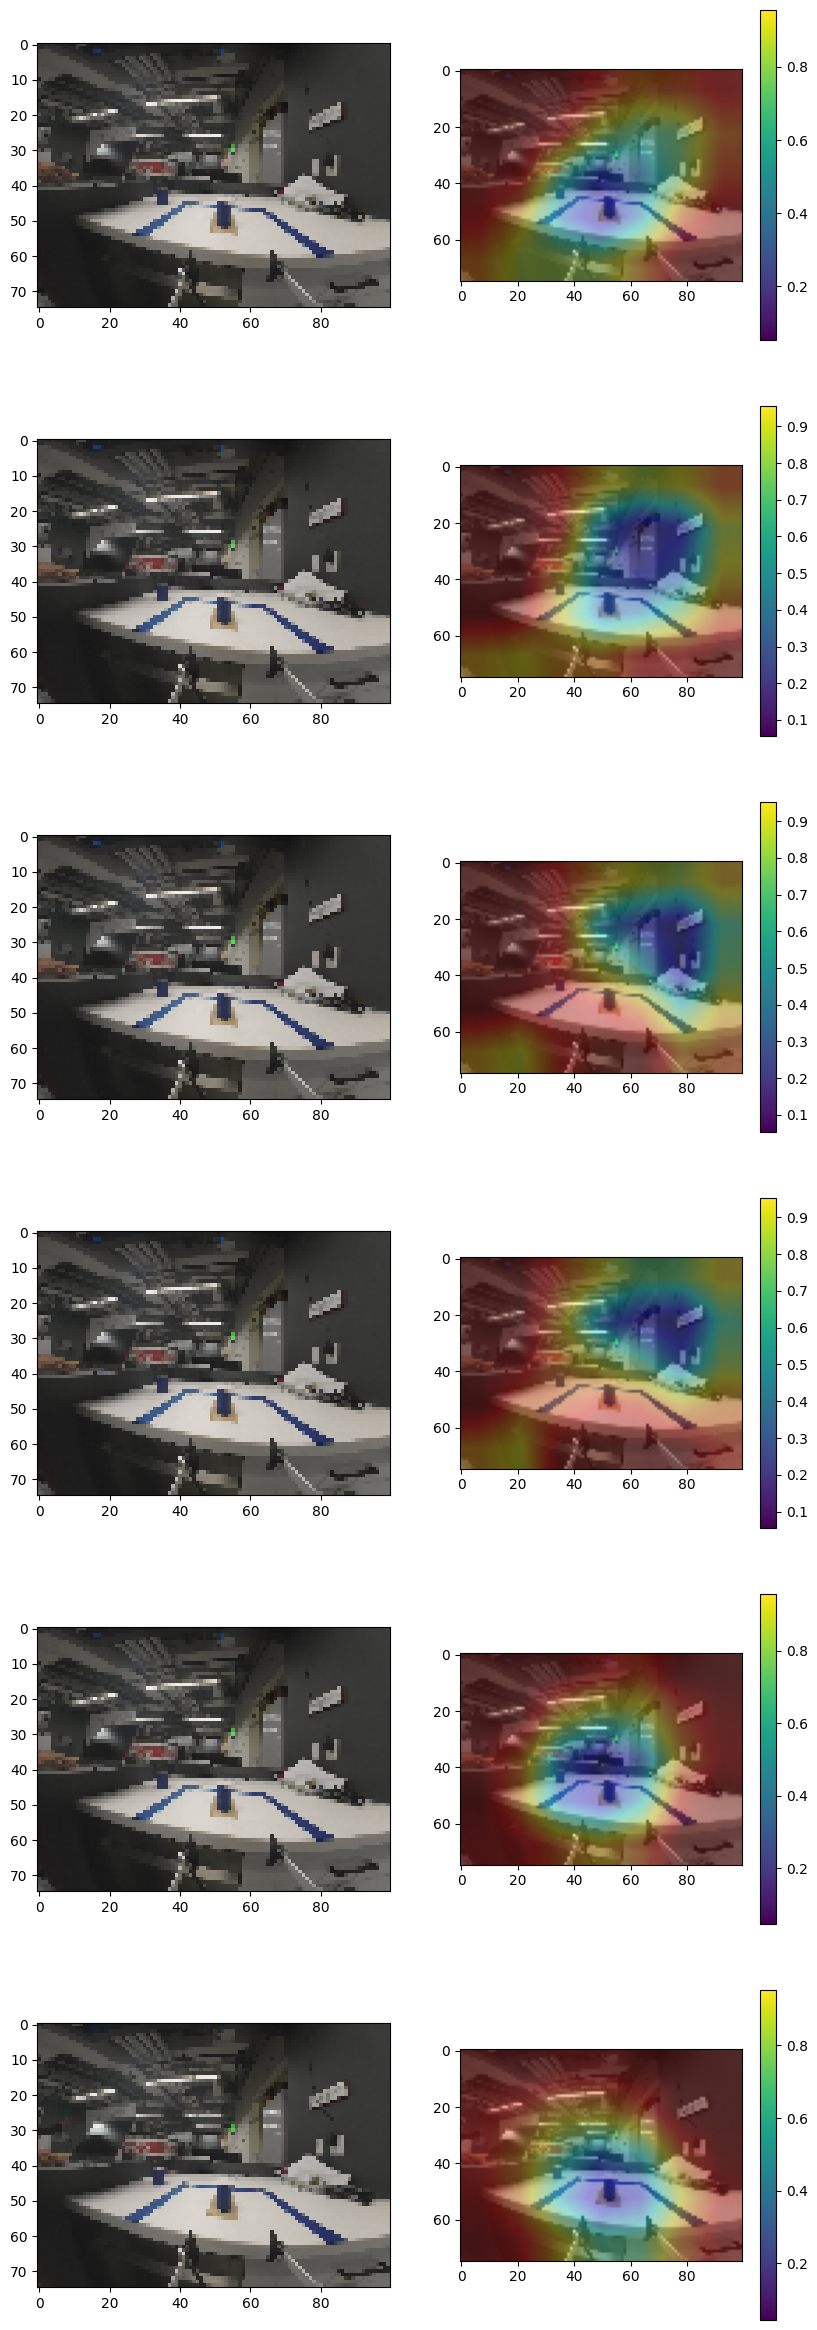

In [5]:
for i, (img, target) in enumerate(val_loader):
    # if i < 100:
    #     continue
    # else:
    #     print(i)
    
    img[0] = img[0][-1]
    # print(img[0].shape)

    inp = {"video": img[0].cuda(), "audio": None}

    # Forward pass through the model
    output = model(inp)
    # plt.imshow(output.cpu().detach().numpy())
    # plt.colorbar()
    # print(output)

    # Obtain the predicted class
    _, predicted_class = torch.max(output.data, 1)
    # print(predicted_class)

    if predicted_class != 0:
        continue

    # Compute the gradients of the predicted class output with respect to the feature maps
    model.zero_grad()
    output[:, predicted_class].backward()

    # Get the gradients from the last convolutional layer
    v_grads, a_grads = model.get_activations_gradient()
    # print("v_grads: ", v_grads.shape) # torch.Size([6, 512, 5, 7])

    # Get the feature maps from the last convolutional layer
    v_maps, a_maps = model.get_activations()
    # print("v_maps: ", v_maps.shape) # torch.Size([6, 512, 5, 7])

    # Perform global average pooling on the gradients
    v_pooled_grads = torch.mean(v_grads, dim=(2, 3))
    # print("v_pooled_grads: ", v_pooled_grads.shape) # torch.Size([6, 512])

    # Multiply each feature map by its corresponding gradient value
    for i in range(v_maps.shape[1]):
        for j in range(v_maps.shape[0]):
            v_maps[j, i, :, :] *= v_pooled_grads[j, i]
    # print("v_maps: ", v_maps.shape) # torch.Size([6, 512, 5, 7])
    
    # Obtain the heatmap by averaging the weighted feature maps
    v_heatmap = torch.mean(v_maps, dim=1).squeeze().cpu()
    # print("v_heatmap: ", v_heatmap.shape) # torch.Size([6, 5, 7])

    # Normalize the heatmap
    v_heatmap = torch.maximum(v_heatmap, torch.zeros_like(v_heatmap))
    # print("v_heatmap: ", v_heatmap.shape) # torch.Size([6, 5, 7])
    # print(type(v_heatmap)) # <class 'torch.Tensor'>
    # print(torch.max(torch.max(v_heatmap, dim=1)[0], dim=1)[0]) 

    v_heatmap_max = torch.max(torch.max(v_heatmap, dim=1)[0], dim=1)[0] # torch.Size([6])
    for i in range(v_heatmap.shape[0]):
        v_heatmap[i] /= v_heatmap_max[i]

    # print("v_heatmap: ", v_heatmap.shape) # torch.Size([6, 5, 7])
    
    # Resize the heatmap to match the input image size
    # print("img[0].shape: ", img[0].shape) # torch.Size([6, 3, 75, 100])

    v_heatmap = v_heatmap.numpy()
    v_heatmap_resized = np.zeros((v_heatmap.shape[0], img[0].shape[2], img[0].shape[3])) # (6, 75, 100)

    for i in range(v_heatmap.shape[0]):
        v_heatmap_resized[i] = cv2.resize(v_heatmap[i], (img[0].shape[3], img[0].shape[2])) # (75, 100)

    v_heatmap_resized = (255 * v_heatmap_resized).astype(np.uint8) 
    v_heatmap_resized = np.minimum(v_heatmap_resized, 255)
    # print("v_heatmap_resized: ", v_heatmap_resized.shape) # (6, 75, 100)   

    # Apply the heatmap to the input image
    superimposed_img_v = np.zeros((v_heatmap.shape[0], img[0].shape[2], img[0].shape[3], 3))
    for i in range(v_heatmap.shape[0]):
        temp_heatmap = cv2.applyColorMap(v_heatmap_resized[i], cv2.COLORMAP_JET) / 255
        # print(min(temp_heatmap.flatten()), max(temp_heatmap.flatten())) # 0 1
        temp_img = img[0][i].cpu().numpy().transpose(1, 2, 0)*0.5 + 0.5
        # print(min(temp_img.flatten()), max(temp_img.flatten())) # 0 1
        superimposed_img_v[i] = temp_heatmap * 0.3 + temp_img * 0.7

    # Display the input image and the GradCAM heatmap with colorbar
    fig, axs = plt.subplots(6, 2, figsize=(10, 30))
    for i in range(6):
        axs[i, 0].imshow(img[0][i].cpu().numpy().transpose(1, 2, 0)*0.5 + 0.5)
        fig.colorbar(axs[i, 1].imshow(superimposed_img_v[i]), ax=axs[i, 1], cmap='jet')

    break